# MDA project: predicting crowdedness in Leuven through noise and weather data

### Importing packages

In [2]:
import pandas as pd
import numpy as np
from matplotlib.patches import Patch
import shap
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import SplineTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error


### Loading data and adding time-related features

In [3]:
df = pd.read_csv("C:/Users/saaan/Downloads/repositories/MDA/ModernDataAnalyticsProject/final_df.csv", delimiter=";")
df['result_timestamp'] = pd.to_datetime(df['result_timestamp'], format='%Y-%m-%d %H:%M:%S')
#select only three locations close to Oude Markt
df = df[df['object_id']<255442]

### Exploratory data analyses

Preprocessing pipeline

In [3]:
#pipeline to create feature matrix with delayed noise and weather data, as well as target vector.

def delay_noise_weather(df):
    # Select columns for df_noisedelay
    df_noisedelay = df[['object_id', 'result_timestamp', 'laeq']]

    # Add 6 hours to result_timestamp
    df_noisedelay['result_timestamp'] += pd.DateOffset(hours=6)

    # Create key column
    df_noisedelay['key'] = df_noisedelay['object_id'].astype(str) + df_noisedelay['result_timestamp'].astype(str)

    # Drop unnecessary columns
    df_noisedelay = df_noisedelay.drop(['laeq', 'object_id', 'result_timestamp'], axis=1)

    # Select columns for df_weatherdelay
    df_weatherdelay = df[['object_id', 'result_timestamp', 'LC_HUMIDITY', 'LC_DWPTEMP', 'LC_n', 'LC_RAD', 'LC_RAININ',
                          'LC_DAILYRAIN', 'LC_WINDDIR', 'LC_WINDSPEED', 'LC_RAD60', 'LC_TEMP_QCL0']]

    # Add 6 hours to result_timestamp
    df_weatherdelay['result_timestamp'] += pd.DateOffset(hours=6)

    # Create key column
    df_weatherdelay['key'] = df_weatherdelay['object_id'].astype(str) + df_weatherdelay['result_timestamp'].astype(str)

    # Drop unnecessary columns
    df_weatherdelay = df_weatherdelay.drop(['object_id', 'result_timestamp'], axis=1)

    # Drop weather-related columns from original df
    df = df.drop(['LC_HUMIDITY', 'LC_DWPTEMP', 'LC_n', 'LC_RAD', 'LC_RAININ',
                  'LC_DAILYRAIN', 'LC_WINDDIR', 'LC_WINDSPEED', 'LC_RAD60', 'LC_TEMP_QCL0'], axis=1)

    # Merge df with df_noisedelay and df_weatherdelay on 'key'
    merged_df = pd.merge(df, df_noisedelay, on='key').merge(df_weatherdelay, on='key')

    # Delete observations with missing values
    merged_df = merged_df.dropna()

    # Create feature matrix X and target vector y
    X = merged_df.drop(['result_timestamp', 'laeq', 'key', 'object_id'], axis=1)
    y = merged_df['laeq']

    # Return feature matrix X and target vector y
    return X, y

#Apply to df
X, y = delay_noise_weather(df)

C:\Users\saaan\AppData\Local\Temp\ipykernel_20624\717413586.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noisedelay['result_timestamp'] += pd.DateOffset(hours=6)
C:\Users\saaan\AppData\Local\Temp\ipykernel_20624\717413586.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noisedelay['key'] = df_noisedelay['object_id'].astype(str) + df_noisedelay['result_timestamp'].astype(str)
C:\Users\saaan\AppData\Local\Temp\ipykernel_20624\717413586.py:21: SettingWithCopyWarning: 
A value is trying to be s

KeyError: 'key'

In [117]:
#temporary 
X = pd.read_csv("C:/Users/saaan/Downloads/repositories/MDA/ModernDataAnalyticsProject/feature_matrix.csv", delimiter=",")
y = pd.read_csv("C:/Users/saaan/Downloads/repositories/MDA/ModernDataAnalyticsProject/target_vector.csv", delimiter=",")



In [118]:
X.info()
#y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130851 entries, 0 to 130850
Data columns (total 28 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   hour          130851 non-null  int64  
 1   day_of_week   130851 non-null  int64  
 2   month         130851 non-null  int64  
 3   weekend       130851 non-null  bool   
 4   holiday       130851 non-null  bool   
 5   exam_period   130851 non-null  bool   
 6   255439        130851 non-null  bool   
 7   255440        130851 non-null  bool   
 8   255441        130851 non-null  bool   
 9   255442        130851 non-null  bool   
 10  255443        130851 non-null  bool   
 11  255444        130851 non-null  bool   
 12  255445        130851 non-null  bool   
 13  280324        130851 non-null  bool   
 14  303910        130851 non-null  bool   
 15  LC_TEMP_QCL1  130851 non-null  float64
 16  LC_TEMP_QCL2  130851 non-null  float64
 17  LC_TEMP_QCL3  130851 non-null  float64
 18  LC_H

Train test split

In [46]:
#create time-sensitive split for cross-validation
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=12000,
    test_size=18000
)

#apply split to the data
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]
train_1, test_1 = all_splits[1]
train_2, test_2 = all_splits[2]
train_3, test_3 = all_splits[3]
train_4, test_4 = all_splits[4]

"""
#visualize train and test sets
# Plotting the training set indices
plt.scatter(X.iloc[train_0].index, X.iloc[train_0]['LC_HUMIDITY']+240, color='green', label='Training Set 1', alpha=0.2, marker='.')
plt.scatter(X.iloc[train_1].index, X.iloc[train_1]['LC_HUMIDITY']+180, color='yellow', label='Training Set 2', alpha=0.2, marker='.')
plt.scatter(X.iloc[train_2].index, X.iloc[train_2]['LC_HUMIDITY']+120, color='red', label='Training Set 3', alpha=0.2, marker='.')
plt.scatter(X.iloc[train_3].index, X.iloc[train_3]['LC_HUMIDITY']+60, color='blue', label='Training Set 4', alpha=0.2, marker='.')
plt.scatter(X.iloc[train_4].index, X.iloc[train_4]['LC_HUMIDITY'], color='purple', label='Training Set 5', alpha=0.2, marker='.')

# Plotting the testing set indices
plt.scatter(X.iloc[test_0].index, X.iloc[test_0]['LC_HUMIDITY']+240, color='black', label='Test Set 1', alpha=0.2, marker='.')
plt.scatter(X.iloc[test_1].index, X.iloc[test_1]['LC_HUMIDITY']+180, color='grey', label='Test Set 2', alpha=0.2, marker='.')
plt.scatter(X.iloc[test_2].index, X.iloc[test_2]['LC_HUMIDITY']+120, color='black', label='Test Set 3', alpha=0.2, marker='.')
plt.scatter(X.iloc[test_3].index, X.iloc[test_3]['LC_HUMIDITY']+60, color='grey', label='Test Set 4', alpha=0.2, marker='.')
plt.scatter(X.iloc[test_4].index, X.iloc[test_4]['LC_HUMIDITY'], color='black', label='Test Set 5', alpha=0.2, marker='.')

plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('Train-Test Split')
plt.show()
"""

"\n#visualize train and test sets\n# Plotting the training set indices\nplt.scatter(X.iloc[train_0].index, X.iloc[train_0]['LC_HUMIDITY']+240, color='green', label='Training Set 1', alpha=0.2, marker='.')\nplt.scatter(X.iloc[train_1].index, X.iloc[train_1]['LC_HUMIDITY']+180, color='yellow', label='Training Set 2', alpha=0.2, marker='.')\nplt.scatter(X.iloc[train_2].index, X.iloc[train_2]['LC_HUMIDITY']+120, color='red', label='Training Set 3', alpha=0.2, marker='.')\nplt.scatter(X.iloc[train_3].index, X.iloc[train_3]['LC_HUMIDITY']+60, color='blue', label='Training Set 4', alpha=0.2, marker='.')\nplt.scatter(X.iloc[train_4].index, X.iloc[train_4]['LC_HUMIDITY'], color='purple', label='Training Set 5', alpha=0.2, marker='.')\n\n# Plotting the testing set indices\nplt.scatter(X.iloc[test_0].index, X.iloc[test_0]['LC_HUMIDITY']+240, color='black', label='Test Set 1', alpha=0.2, marker='.')\nplt.scatter(X.iloc[test_1].index, X.iloc[test_1]['LC_HUMIDITY']+180, color='grey', label='Test Set

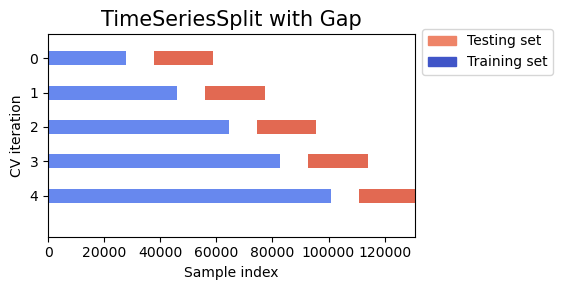

In [15]:

#some variables
cmap_cv = plt.cm.coolwarm
n_splits = 5

# Generate the dataset
n_points = len(X.index)
X = X
y = y

def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0
        
        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )
    
    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(
        yticks=np.arange(n_splits) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 0.7, -0.2],
        xlim=[0, n_points],
    )
    ax.set_title("TimeSeriesSplit with Gap", fontsize=15)
    return ax

# Visualize cross-validation indices for TimeSeriesSplit with Gap
fig, ax = plt.subplots(figsize=(6, 3))
gap = 12960
test_size = 18340
cv = TimeSeriesSplit(n_splits, gap=gap, test_size=test_size)
plot_cv_indices(cv, X, y, ax, n_splits)

ax.legend(
    [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
    ["Testing set", "Training set"],
    loc=(1.02, 0.8),
)
# Make the legend fit
plt.tight_layout()
fig.subplots_adjust(right=0.7)
plt.show()


### Pipelines to fit all models (with cross-validation and hyperparameter tuning)

Create pipeline for Ridge with spline transformations

In [63]:
#preparing transformations and features for the Ridge regression
def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

#creating spline transformers
cyclic_spline_transformer = ColumnTransformer(
    transformers=[
        ("cyclic_month", periodic_spline_transformer(12, n_splines=6), ["month"]),
        ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3), ["day_of_week"]),
        ("cyclic_hour", periodic_spline_transformer(24, n_splines=12), ["hour"]),
    ],
    #remainder=MinMaxScaler(),
)

#creating interactions
hour_holiday_interaction = make_pipeline(
    ColumnTransformer(
        [
            ("cyclic_hour", periodic_spline_transformer(24, n_splines=8), ["hour"]),
            ("holiday", FunctionTransformer(lambda x: x == 1), ["holiday"]),
        ]
    ),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
)

day_holiday_interaction = make_pipeline(
    ColumnTransformer(
        [
            ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3), ["day_of_week"]),
            ("holiday", FunctionTransformer(lambda x: x == 1), ["holiday"]),
        ]
    ),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
)

hour_weekend_interaction = make_pipeline(
    ColumnTransformer(
        [
            ("cyclic_hour", periodic_spline_transformer(24, n_splines=8), ["hour"]),
            ("weekend", FunctionTransformer(lambda x: x == 1), ["weekend"]),
        ]
    ),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
)

#creating a standardization function for the numeric variables
scaling_features=['LC_HUMIDITY','LC_TEMP_QCL0','LC_RAD60','LC_WINDSPEED','LC_WINDDIR','LC_DAILYRAIN','LC_RAININ','LC_RAD','LC_n','LC_DWPTEMP']
standardize=ColumnTransformer(
    [
        ("standardization",StandardScaler(),scaling_features)
    ],
)

Evaluate different models and select best performing model

In [65]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Create the pipelines
pipelines = [
    ('Ridge', Pipeline([
    ('features', FeatureUnion([
        ("marginal", cyclic_spline_transformer),
        ("interactions1", hour_weekend_interaction),
        ("interactions2", day_holiday_interaction),
        ("interactions3", hour_holiday_interaction),
        ('standardize', standardize)
    ])),
    ('model', Ridge())
    ])),
    ('Gradient Boosting', Pipeline([('model', HistGradientBoostingRegressor())
    ])),
    ('XGBoost', Pipeline([('model', XGBRegressor())
    ]))
]

In [83]:
def find_best_parameters(X, y):
    # Split the data into features (X) and target (y)
    
    # Define the parameter grids for GridSearchCV
    param_grids = {
        'Ridge': {'model__alpha': np.logspace(-6, 6, 25)},

        'Gradient Boosting': {
            'model__learning_rate': [0.05, 0.06],
            'model__max_leaf_nodes': [9, 10]
        },

        'XGBoost': {
            'model__learning_rate': [0.05, 0.06],
            'model__n_estimators': [100, 110],
            'model__max_depth': [5, 6]
        }
    }
    best_pipeline = None
    best_params = None
    best_score = -float('inf')

    # Perform grid search using cross-validation for each pipeline
    for pipeline_name, pipeline in pipelines:
        param_grid = param_grids[pipeline_name]
        scorer = 'neg_mean_squared_error'
        #grid_search = GridSearchCV(pipeline, param_grid, cv=5)
        grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=ts_cv, scoring=scorer)
        grid_search.fit(X, y)

        # Print the best parameters and score for the current pipeline
        print(pipeline_name, "- Best Parameters: ", grid_search.best_params_)
        score = -grid_search.best_score_
        print(pipeline_name, "- Best Score: ", score)
        print("-----")

        if grid_search.best_score_ > best_score:
            best_pipeline = pipeline
            best_params = grid_search.best_params_
            best_score = grid_search.best_score_
    
    # Set the best parameters to the best pipeline
    best_pipeline.set_params(**best_params)

    # Return the best pipeline with the best parameters
    return best_pipeline
final_pipeline=find_best_parameters(X, y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


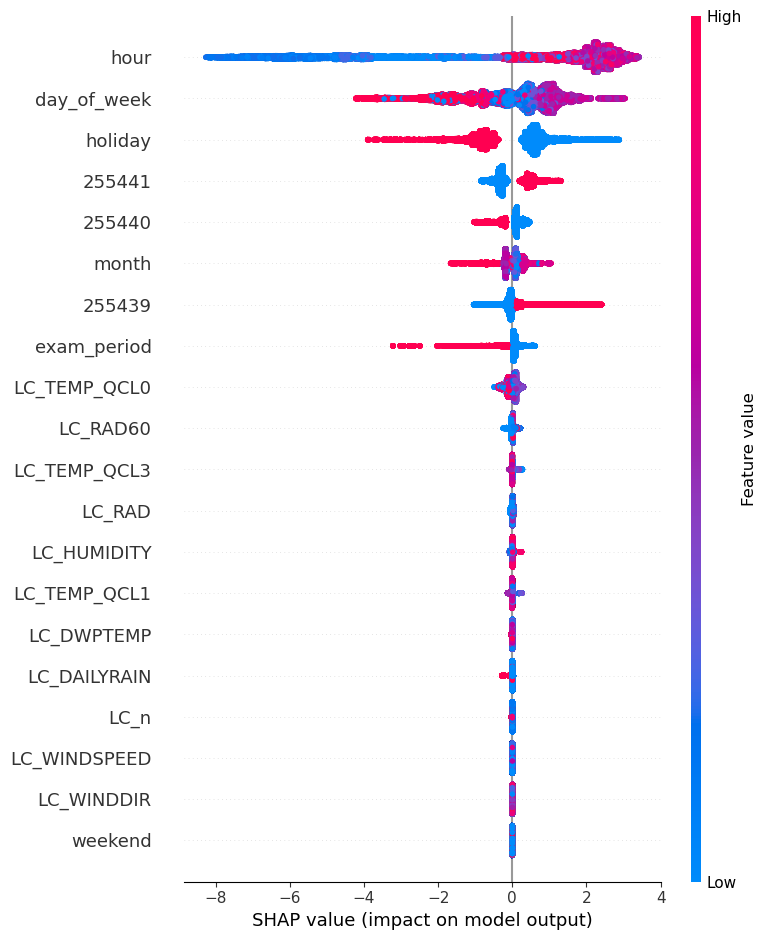

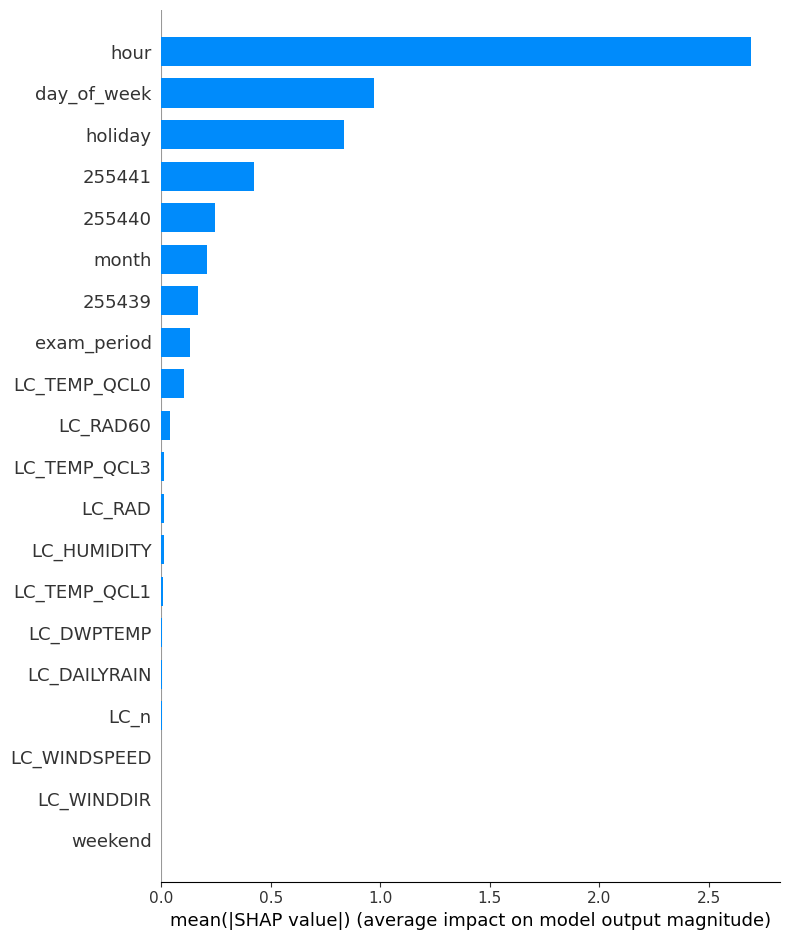

In [137]:
def get_important_features(X,y,pipeline,cutoff):
    pipeline.fit(X,y)
    explainer = shap.Explainer(pipeline.steps[-1][1])
    shap_values = explainer.shap_values(X)

    

    #summary plot
    shap.summary_plot(shap_values, X)
    #bar chart
    shap.summary_plot(shap_values, X, plot_type="bar")
    #explain a single prediction: see https://www.kaggle.com/code/dansbecker/shap-values
    shap.initjs()
    shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])
    # explain more predictions: don't really know how this works
    #shap.force_plot(explainer.expected_value, shap_values[:500,:], X.iloc[:500,:])
   

    # Calculate average absolute Shapley value for each feature
    avg_shap_values = pd.DataFrame(shap_values, columns=X.columns).abs().mean()
    sorted_features = avg_shap_values.sort_values(ascending=False)
    # Select top-k features based on the cutoff point
    selected_features = sorted_features[sorted_features >= cutoff].index.tolist()
    return X.loc[:, selected_features]
    #return(selected_features)

X_2=get_important_features(X,y,final_pipeline,0.01)


In [136]:
X_2.head()

,hour,day_of_week,holiday,255441,255440,month,255439,exam_period,LC_TEMP_QCL0,weekend,LC_RAD60,LC_TEMP_QCL3,LC_RAD,LC_HUMIDITY
0,6,5,True,True,False,1,False,False,13.28,True,0.0,11.54982,0.0,91.0
1,6,5,True,True,False,1,False,False,13.28,True,0.0,11.52837,0.0,90.0
2,6,5,True,True,False,1,False,False,13.28,True,0.0,11.52966,0.0,90.0
3,6,5,True,True,False,1,False,False,13.28,True,0.0,11.55408,0.0,90.0
4,6,5,True,True,False,1,False,False,13.28,True,0.0,11.72889,0.0,90.0


### Visualization of results of final model

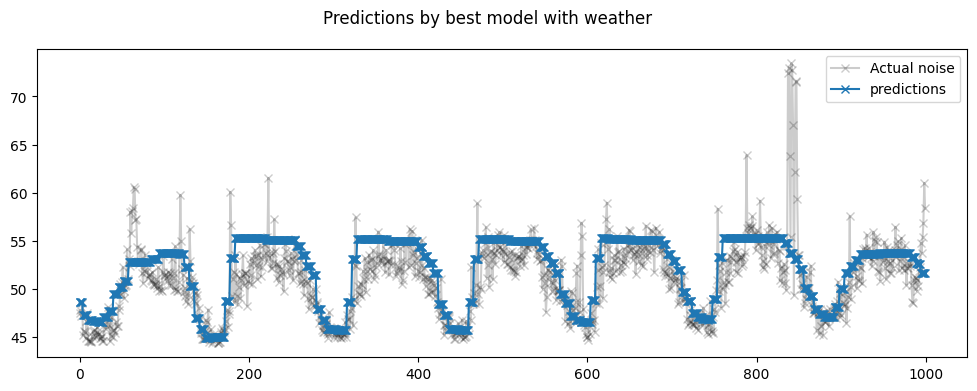

In [14]:
#visualization of model predictions, trained on full data
best_model.fit(X, y)
best_model_predictions = best_model.predict(X)

last_hours = slice(-1000, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by best model with weather")
ax.plot(
    y.values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual noise",
    color="black",
)
ax.plot(best_model_predictions[last_hours], "x-", label="predictions")
_ = ax.legend()


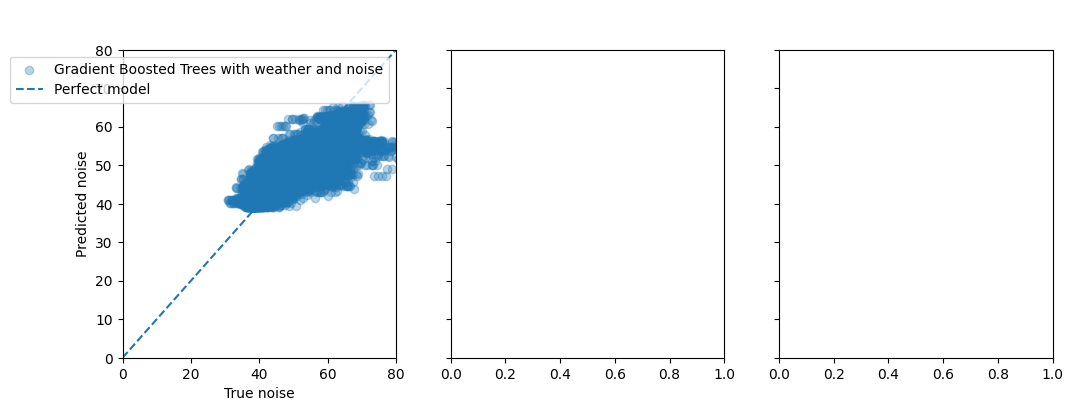

In [16]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle(" ")
predictions = [
    best_model_predictions,
]
labels = [
    "Gradient Boosted Trees with weather and noise",
]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(y.values, pred, alpha=0.3, label=label)
    ax.plot([0, 80], [0, 80], "--", label="Perfect model")
    ax.set(
        xlim=(0, 80),
        ylim=(0, 80),
        xlabel="True noise",
        ylabel="Predicted noise",
    )
    ax.legend()

plt.show()

Shapley values